In [1]:
import shuo
import numpy as np
import networkx as nx
import geopandas as gpd
from simplemaps.SimpleFigures import simpleMap
from shuo.basics import FileNames, PickleDataWriter as pdw, UnionFind, FilesReader
from shuo.optimization import graph_of_minimizing_number_of_connected_components

File_Prefixes = ['Washington_DC', 
                 'Seattle_city_WA',
                 'Chicago_city_IL',
                 'Madison_county_AL', 
                 'Mobile_city_AL', 
                 'Napa_city_CA', 
                 'Redding_city_CA',
                 'Yuma_county_AZ']
budget = 0
current_index = 0
folder = 'data_processed'
file_prefix = File_Prefixes[current_index]
print(file_prefix)

N = FileNames(folder, file_prefix, budget)
F = FilesReader(folder, file_prefix, budget)

shapefileFn='data/raw/zone/taz-20190709T172404Z-001/taz/Traffic_Analysis_Zones.shp'
shapefileKey='TAZ'

# Load travel demand matrix
demand_matrix = F.travel_demand_matrix()
print('Total trips:', np.sum(demand_matrix))
zones_num = demand_matrix.shape[0]

# Load TAZ data
df = gpd.read_file(shapefileFn)

Washington_DC
Total trips: 644337.6419999999


# Original - Number of outgoing trips per zone (TAZ)

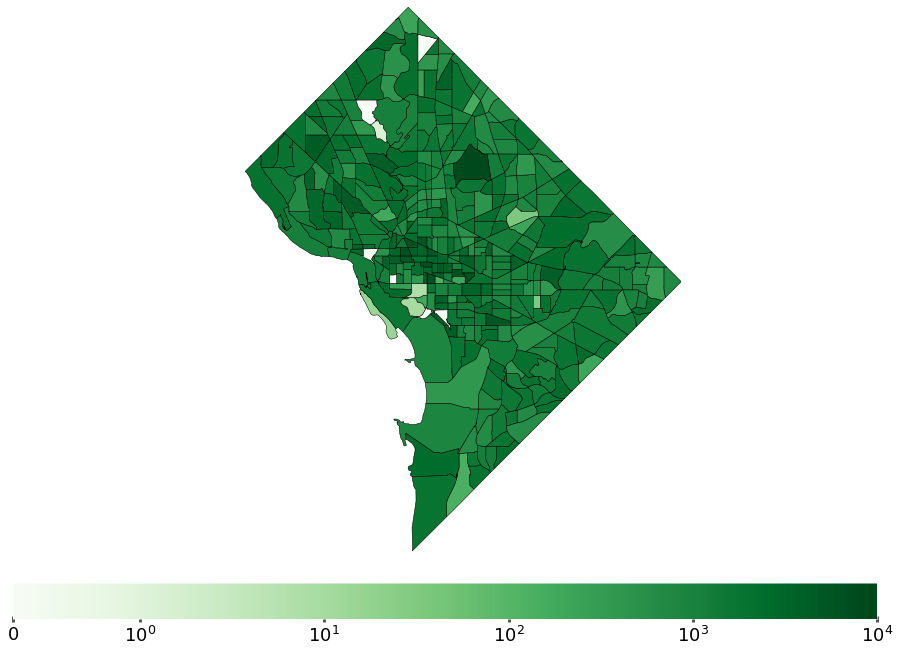

In [2]:
# Calculate outgoing matrix
outgoing_matrix = [np.sum(demand_matrix[i]) for i in range(zones_num)]

# Get color dictionary: "data"
data = {row[shapefileKey]: outgoing_matrix[row[shapefileKey] - 1] for zone_index, row in df.iterrows()}

# Show graph
np.seterr(all="ignore")
simpleMap(cmap="Greens", noDataColor="#000000", logScale=True, data=data, shapefileFn=shapefileFn, shapefileKey=shapefileKey)

# Original - Number of infeasible outgoing trips per zone (TAZ)

Estimated total infeasible trips: 187388.4444036483


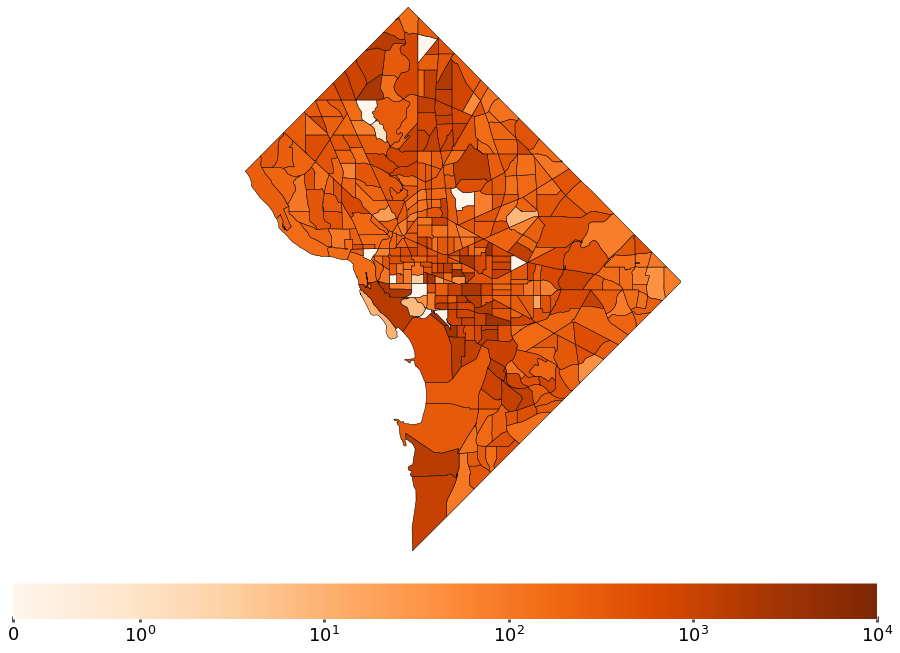

In [3]:
budget = 0
N.update_budget(budget)
F.update_budget(budget)

# Load trips count matrix of flooded road network
[feasible_trips_count, infeasible_trips_count] = F.zone_trips_count_matrix(1)
total_trips_count = feasible_trips_count + infeasible_trips_count
total_trips_count[total_trips_count == 0] = 1
zones_num = total_trips_count.shape[0]

# Calculate estimated infeasible travel demand matrix
est_demand_matrix = demand_matrix * (infeasible_trips_count / total_trips_count)

# Calculate outgoing matrix
outgoing_matrix = [np.sum(est_demand_matrix[i]) for i in range(zones_num)]
print('Estimated total infeasible trips:', np.sum(est_demand_matrix))

# Get color dictionary: "data"
data = {row[shapefileKey]: outgoing_matrix[row[shapefileKey] - 1] for zone_index, row in df.iterrows()}

# Show graph
np.seterr(all="ignore")
simpleMap(cmap="Oranges", noDataColor="#000000", colorbarRange=(0, 10000), logScale=True, data=data, shapefileFn=shapefileFn, shapefileKey=shapefileKey)

# Optimized - Number of infeasible outgoing trips per zone (TAZ)

In [4]:
# Load original flooded graphs
UG, AG = F.graph(1), F.graph(2)
nodes_num = len(UG.nodes())

# Load mappings
dict_index_to_node, dict_node_to_index = F.mapping(0)
dict_index_to_zone, dict_zone_to_index = F.mapping(1)
dict_zone_to_nodes, dict_node_to_zones = F.mapping(2)
dict_zone_ind_to_node_incs, dict_node_ind_to_zone_incs = F.mapping(3)
zones_num = len(dict_zone_to_index)

In [5]:
# Load the recovered graph
budget = 500
F.update_budget(budget)
N.update_budget(budget)
opt = 'minimizing_infeasible_trips'
NG = F.graph(3, opt)

# Recompute or load node_distance_matrix
recompute = False
if recompute:
    node_dist_mat = shuo.nodes_distances(NG, dict_node_to_index)
    np.save(N.node_distance_matrix(1, opt), node_dist_mat)
else:
    node_dist_mat = F.node_distance_matrix(1, opt)
    
# Recompute or load zone_distance_matrix and trips_count_matrix
recompute = False
if recompute:
    [feasible_trips_count, infeasible_trips_count] = shuo.zones_distances_and_trips_count(node_dist_mat, dict_index_to_node, dict_node_to_zones, dict_zone_to_index)[1]
    np.save(N.zone_trips_count_matrix(1, opt), [feasible_trips_count, infeasible_trips_count])
else:
    [feasible_trips_count, infeasible_trips_count] = F.zone_trips_count_matrix(1, opt)
    
# Recompute or load travel_demand_matrix
recompute = False
if recompute:
    demand_matrix = get_travel_demand_from_TAZ(zones_num, range(1, zones_num + 1), 'data/raw/travel_demand/WenWen/raw_2017/DY_VEHICLE_TRIPS_2017_V2.3.70_All.CSV')
    np.save(N.travel_demand_matrix(), demand_matrix)
else:
    demand_matrix = F.travel_demand_matrix()

Remaining Infeasible Trips: 31942.46301936698
Recovered Infeasible Trips: 155445.9813842813


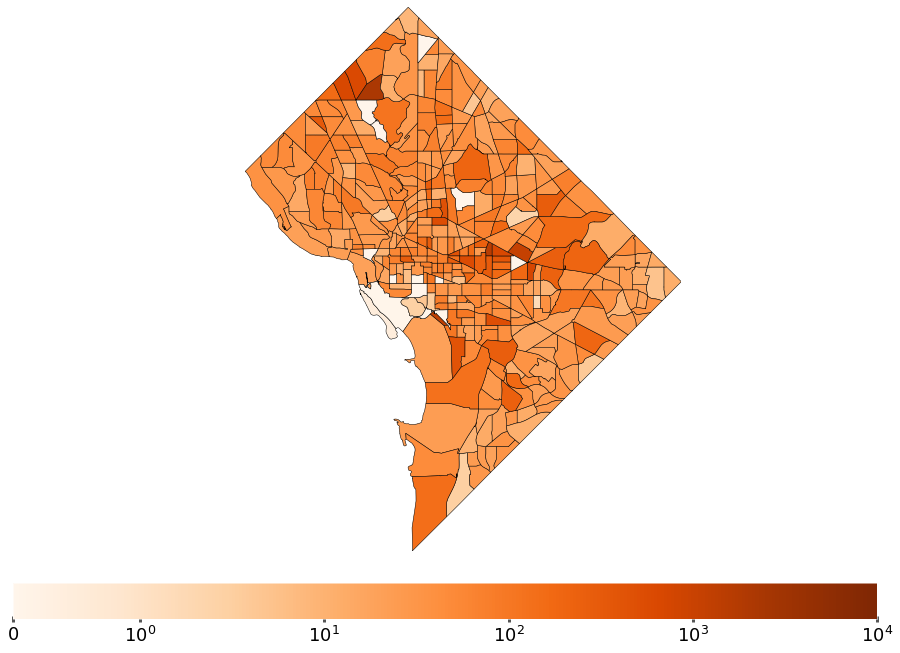

In [6]:
# Calculate estimated infeasible travel demand matrix
est_demand_matrix_2 = demand_matrix * (infeasible_trips_count / total_trips_count)

# Calculate outgoing matrix 
outgoing_matrix_2 = [np.sum(est_demand_matrix_2[i]) for i in range(zones_num)]

# Get color dictionary: "data"
data = {row[shapefileKey]: outgoing_matrix_2[row[shapefileKey] - 1] for zone_index, row in df.iterrows()}

print('Remaining Infeasible Trips:', np.sum(outgoing_matrix_2))
print('Recovered Infeasible Trips:', np.sum(est_demand_matrix) - np.sum(est_demand_matrix_2))

# Show graph
np.seterr(all="ignore")
simpleMap(cmap="Oranges", noDataColor="#000000", colorbarRange=(0, 10000), logScale=True, data=data, shapefileFn=shapefileFn, shapefileKey=shapefileKey)